In [1]:
EXPERIMENT_NAME = "medium_model_no_sampling"

In [2]:
import copy
import json
import os
import pandas as pd
import sys
import numpy as np
from explain_model_helpers import ShapModel, get_config, patient_heatmap, global_heatmap, global_importance_plot, predict_per_patient, get_pred_threshold, compute_base_value, strip_padding
from final_pipeline import ModelWrapper, get_data, setup_device
from full_pipeline import find_project_root
from preprocess import over_under_sample
import pickle as pkl 
import torch 
import shap 
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm
import pickle as pkl


Load the saved shap vals

In [3]:
root = find_project_root()
shap_vals = np.load(os.path.join(root, "models", "model_B", "results", EXPERIMENT_NAME, "shap", "shap_vals.npy"))
masks = np.load(os.path.join(root, "models", "model_B", "results", EXPERIMENT_NAME, "shap", "masks.npy"))

In [4]:
print(shap_vals.shape)
print(masks.shape)

(1172, 400, 107)
(1172, 400)


Get feature names

In [5]:
config = get_config(root, EXPERIMENT_NAME)
config["testing"]["batch_size"] = 32
config["training"]["batch_size"] = 32
config["testing"]["num_workers"] = 1
config["training"]["num_workers"] = 1
eval_data = get_data(config, "shap_eval")


Average at patient level

In [6]:
global_shap_vals = np.mean(avg_shap_vals, axis=0)
shap.plots.bar(shap.Explanation(global_shap_vals, feature_names=feature_names), show=False)
ax = plt.gca()
for txt in ax.texts:
    txt.remove()
fmt = ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-4, -4))
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.get_offset_text().set_x(1.02)
ax.xaxis.get_offset_text().set_fontsize(12)
#set the title
plt.title("Top Features")
plt.tight_layout()
plt.show()

NameError: name 'avg_shap_vals' is not defined

Get the patient ids and labels for the data

In [8]:
device = setup_device()
in_dim = eval_data.X.shape[1]
model = ModelWrapper(config, device, in_dim)
model.load_saved_weights()

val_data = get_data(config, "val")

pred_threshold = get_pred_threshold(model, val_data, device, config)

patient_ids, y_trues, y_preds, y_probs, xvals = predict_per_patient(model, eval_data, device, pred_threshold)

Using MPS device
Pos weight: 12.77


/Users/aidend/Developer/ds_uni/dl-sepsis-prediction/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Predicting per patient: 100%|██████████| 19/19 [00:01<00:00, 14.63it/s]


In [9]:
a = np.concatenate(xvals, axis=1)
print(a.shape)
a = np.transpose(a, (1, 0, 2))
print(a.shape)
xvals = a


(400, 1172, 107)
(1172, 400, 107)


In [10]:
xvals.shape

(1172, 400, 107)

In [11]:
def unscale_matrix(xvals, scaler):
    """
    Un-scale a batch of matrices by:
      1. Inserting a zero-column at feature index 38 (to match the scaler’s original feature count)
      2. Calling scaler.inverse_transform on the flattened data
      3. Removing the dummy column at index 38
    Args:
      xvals: np.ndarray of shape (P, T, F)
      scaler: an sklearn-like scaler fitted on data with F+1 features
    Returns:
      unscaled: np.ndarray of shape (P, T, F)
    """
    P, T, F = xvals.shape
    insert_idx = 38

    # 1) insert a zero column at axis=2
    x_with_blank = np.insert(xvals, insert_idx, 0.0, axis=2)  # shape → (P, T, F+1)

    # 2) reshape to 2D (samples, features) for scaler
    flat = x_with_blank.reshape(-1, F + 1)                      # shape → (P*T, F+1)

    # inverse transform
    flat_inv = scaler.inverse_transform(flat)                   # shape → (P*T, F+1)

    # reshape back to 3D
    inv_3d = flat_inv.reshape(P, T, F + 1)                      # shape → (P, T, F+1)

    # 3) drop the dummy column, restoring (P, T, F)
    unscaled = np.delete(inv_3d, insert_idx, axis=2)

    return unscaled

In [12]:
base_values = compute_base_value(model, eval_data, device)

Computing base value: 100%|██████████| 19/19 [00:01<00:00, 16.69it/s]


In [13]:
old_patient_ids = patient_ids
matrix = np.zeros((len(patient_ids), 108))
matrix[:, 38] = patient_ids

with open(os.path.join(root, "dataset", "final_datasets", "scaler.pkl"), "rb") as f:
    scaler = pkl.load(f)

matrix = scaler.inverse_transform(matrix)
patient_ids = np.round(matrix[:, 38]).astype(int)
old_new_map = {old: new for old, new in zip(old_patient_ids, patient_ids)}

eval_df = eval_data.df
eval_df["patient_id"] = eval_df["patient_id"].map(old_new_map)

In [14]:
new_xvals = unscale_matrix(xvals, scaler)
xvals = new_xvals

In [18]:
np.unique(new_xvals[:, :, 35])

array([-1.8080573e-08,  5.5809379e-01,  1.0000000e+00], dtype=float32)

In [19]:
import pandas as pd

In [20]:
#filter out patients with more than 30 time steps
filtered_eval_df = eval_df.groupby("patient_id").filter(lambda x: len(x) <= 30)

pos_patients = filtered_eval_df[filtered_eval_df["SepsisLabel"] == 1].sample(10, random_state=42)
neg_patients = filtered_eval_df[filtered_eval_df["SepsisLabel"] == 0].sample(0, random_state=42)
# put their patient ids in a list
sample_ids = np.concatenate([pos_patients["patient_id"].tolist(), neg_patients["patient_id"].tolist()])
sample_ids = list(np.array(sample_ids))

In [21]:
patient_id_index_map = {patient_id: i for i, patient_id in enumerate(patient_ids)}

In [22]:
print(base_values)

1.8645216


In [33]:
import pandas as pd
import seaborn as sns
def patient_heatmap(
    shap_vals: np.ndarray,
    feature_names,
    time_index,
    idx: int,
    patient_id: str,
    y_true: float,
    y_pred: float,
    y_prob: float,
    *,
    only_target_relevant: bool = True,
    show: bool = True,
    top_features: list[int] | np.ndarray | None = None,
    annot_df: pd.DataFrame | None = None,
):
    """Plot a SHAP heat-map for a *single* patient and optionally return the figure."""

    # Truncate padding --------------------------------------------------------
    patient_data = copy.deepcopy(shap_vals[idx])  # (T, F)
    valid_time_index, valid_patient_data = strip_padding(patient_data, time_index)
    annot_df = annot_df.iloc[: valid_time_index.shape[0]]

    # Focus on SHAP values relevant to the *target class* ---------------------
    if only_target_relevant:
        valid_patient_data = np.clip(
            valid_patient_data,
            a_min=0 if y_true == 1 else None,
            a_max=0 if y_true == 0 else None,
        )

    # Top-k most relevant features -------------------------------------------
    if top_features is None:
        mean_importance = np.abs(valid_patient_data).mean(axis=0)
        top_features = np.argsort(-mean_importance)[: CONFIG.top_k_features]
    top_feature_names = np.array(feature_names)[top_features]

    # Plot --------------------------------------------------------------------
    fig, ax = plt.subplots(
        figsize=(max(10, valid_time_index.shape[0] * 0.1), 8),
        constrained_layout=True,
    )
    if annot_df is not None:
        annot_to_use_raw = annot_df.iloc[:, top_features].T.values
        # Format numbers to 1 decimal place, as strings (avoids scientific notation)
        annot_to_use = np.vectorize(lambda x: f"{x:.1f}")(annot_to_use_raw)
    else:
        annot_to_use = None

    sns.heatmap(
        valid_patient_data[:, top_features].T,
        cmap="vlag",
        center=0,
        yticklabels=top_feature_names,
        xticklabels=valid_time_index,
        annot=annot_to_use,
        ax=ax,fmt='s',
    )
    ax.set_title(
        (
            f"Patient ID: {int(patient_id)}, Actual: {int(y_true)}, Predicted: {int(y_pred)}"
        ),
        fontsize=14,
    )
    ax.set_xlabel("ICU LOS (hours)")
    ax.set_ylabel("Feature")

    if show:
        plt.show()
    return fig

In [53]:
def apply_mask(xvals, mask):
    true_mask = np.where(mask == 1)[0]
    return xvals[true_mask, :]

def apply_mask_shap(shap_vals, mask):
    true_mask = np.where(mask == 1)[0]
    return shap_vals[true_mask, :]

(1172, 400)
(57226,)


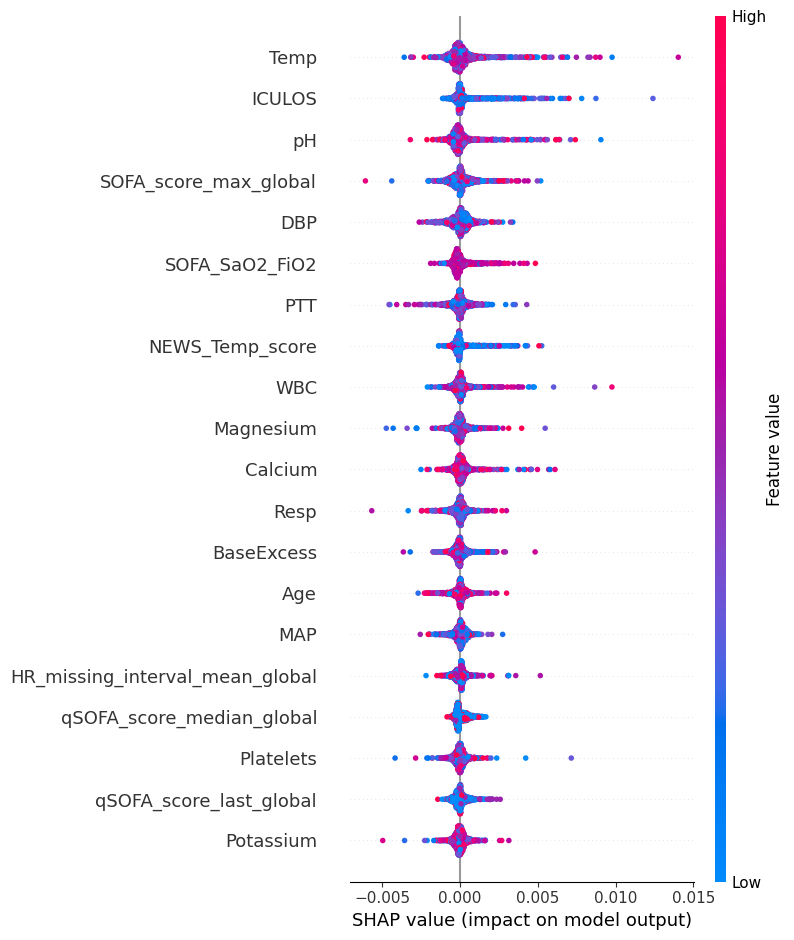

In [54]:
feature_names = eval_data.X.columns.tolist() # (F)
feature_names = np.array(feature_names)
avg_shap_vals = copy.deepcopy(shap_vals) # (P, T, F)
avg_shap_vals = np.mean(shap_vals, axis=1)  # (P, F)
# compute a masked mean shap value
# avg_shap_vals = np.mean(apply_mask_shap(shap_vals, masks), axis=0)

avg_data_df= eval_data.df.groupby("patient_id").mean().reset_index() # (P, F)
avg_data_df = avg_data_df[feature_names]

shap.summary_plot(avg_shap_vals, avg_data_df, feature_names=feature_names)

Actual:  1.0
Predicted:  0


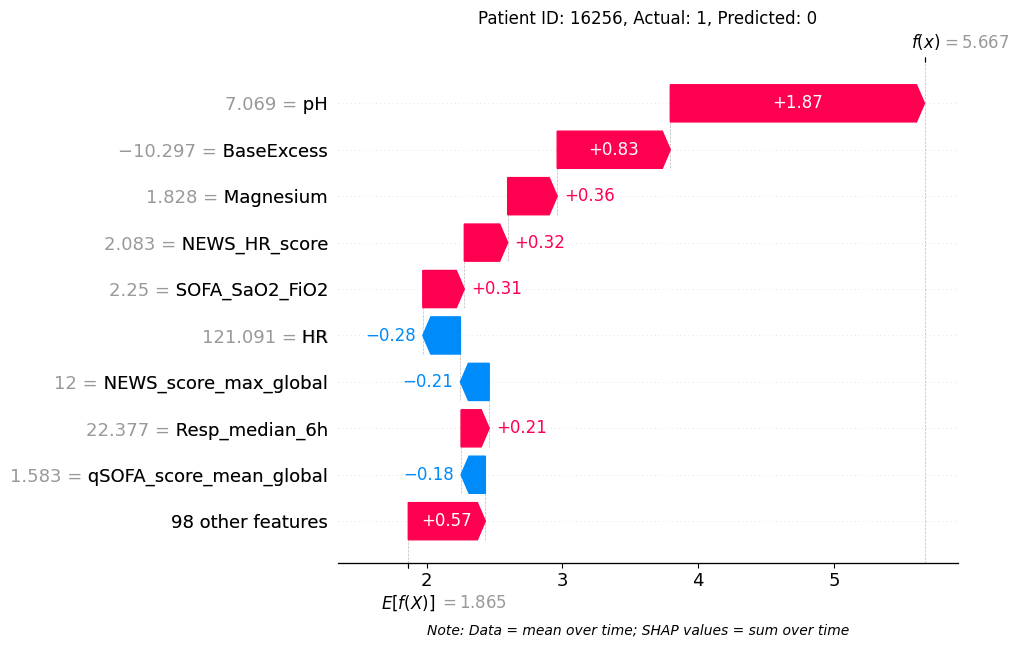

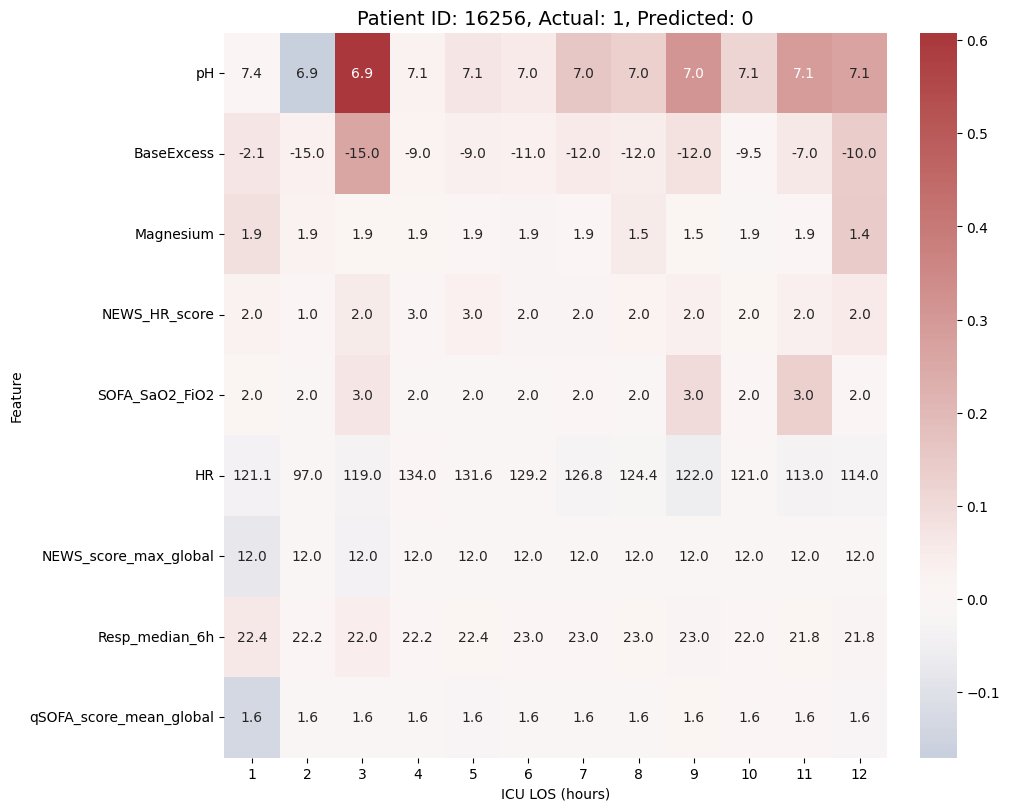

Actual:  1.0
Predicted:  0


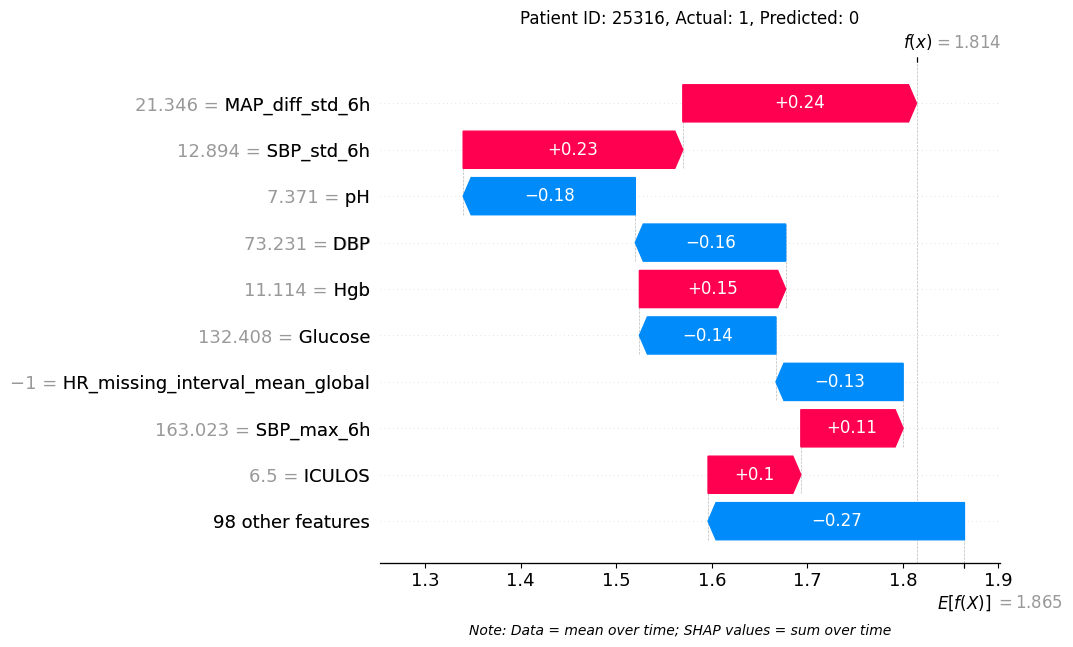

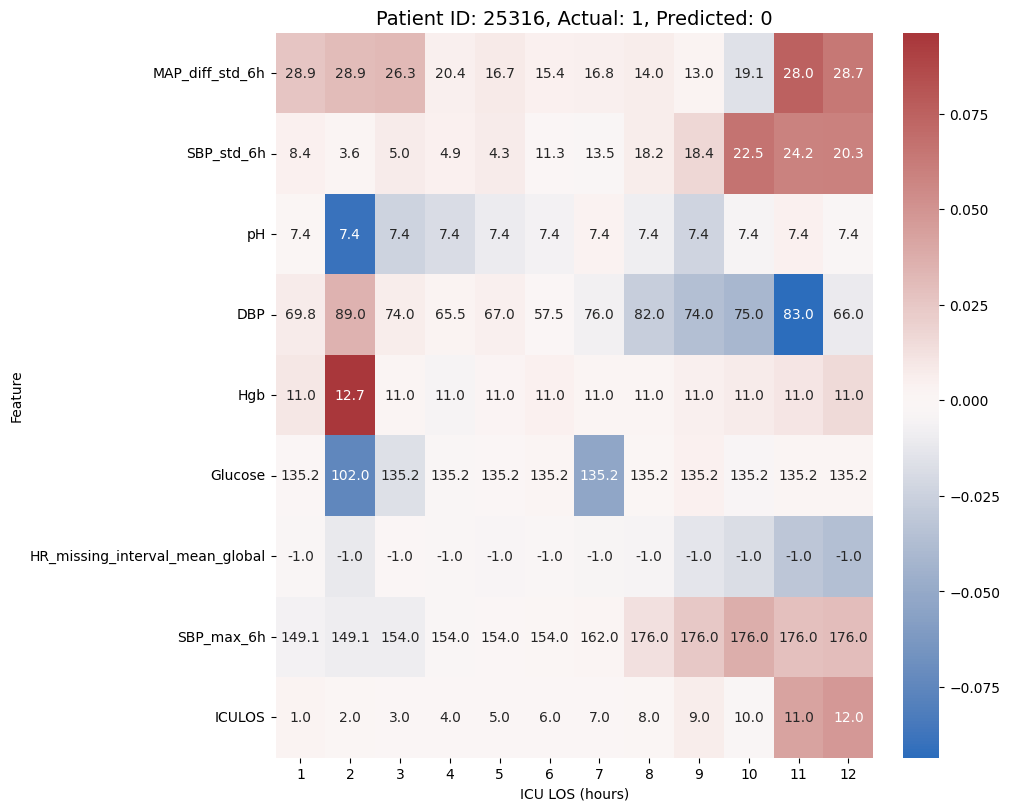

Actual:  1.0
Predicted:  1


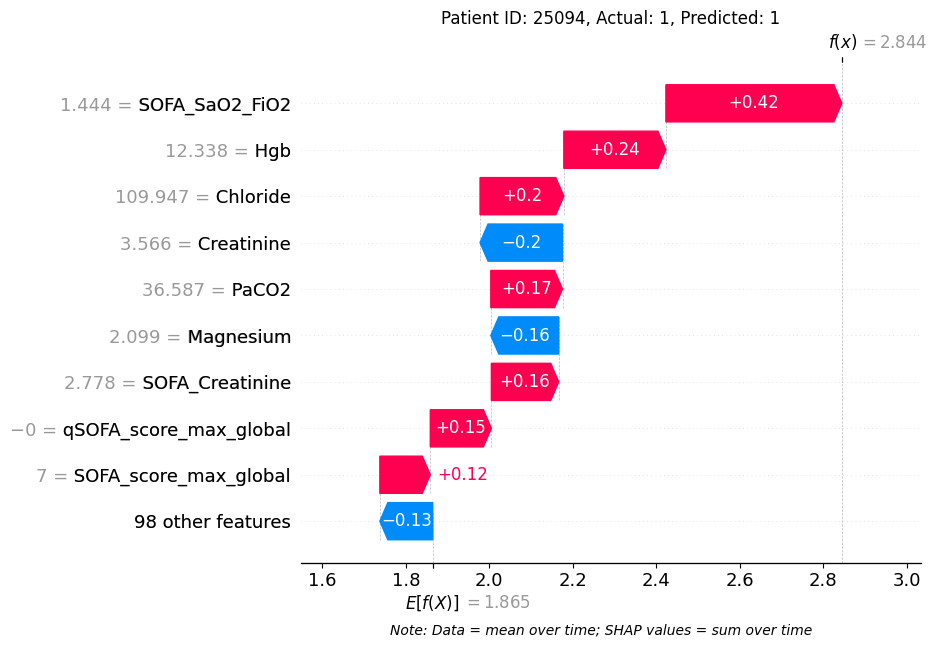

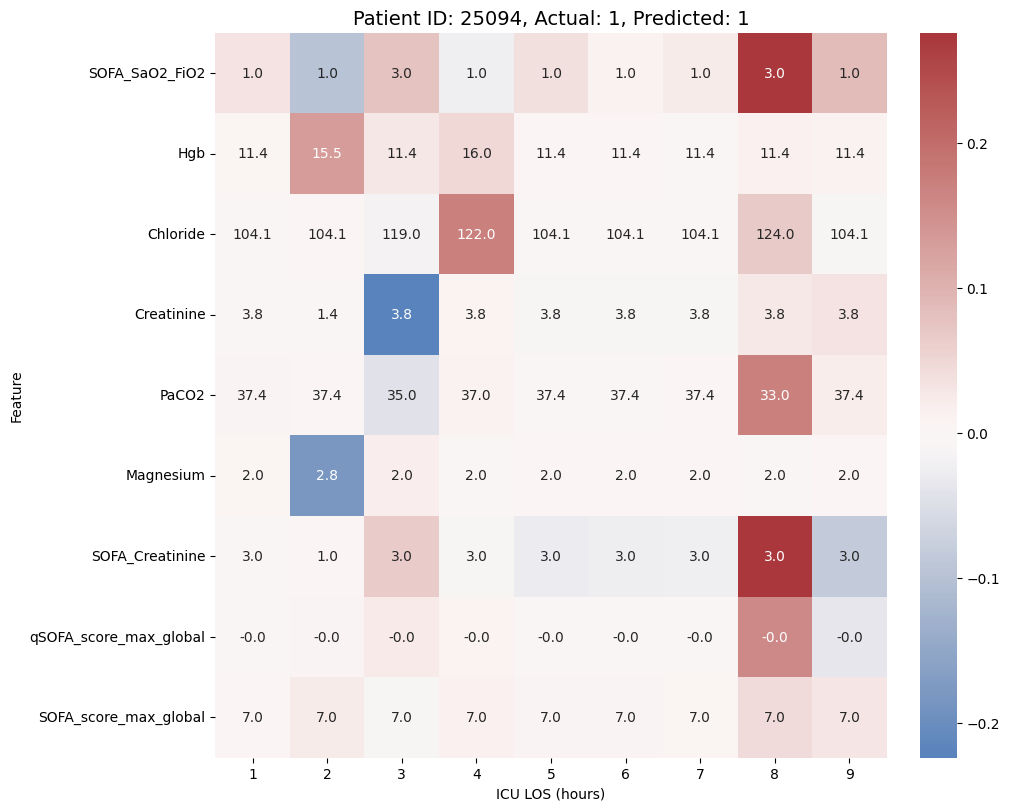

Actual:  1.0
Predicted:  0


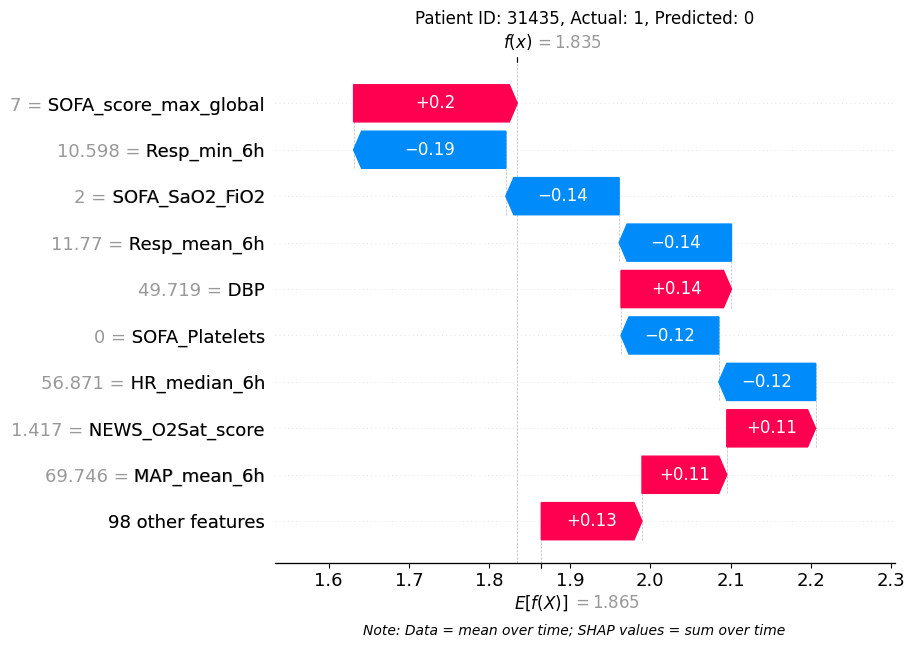

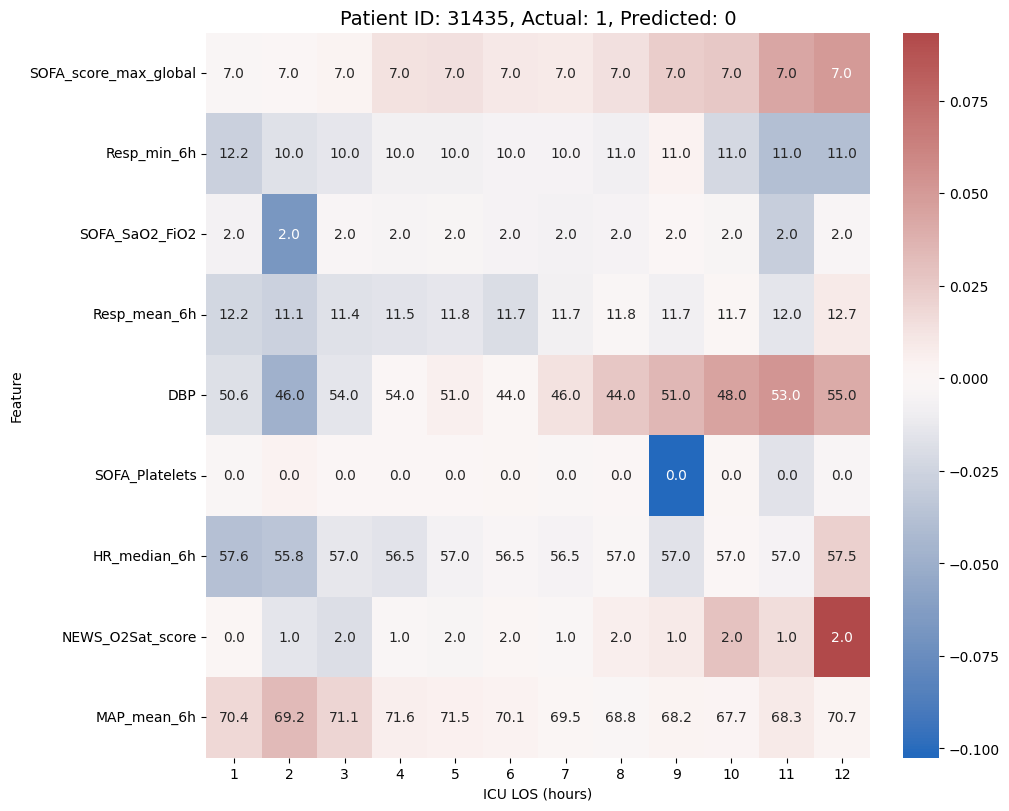

Actual:  1.0
Predicted:  1


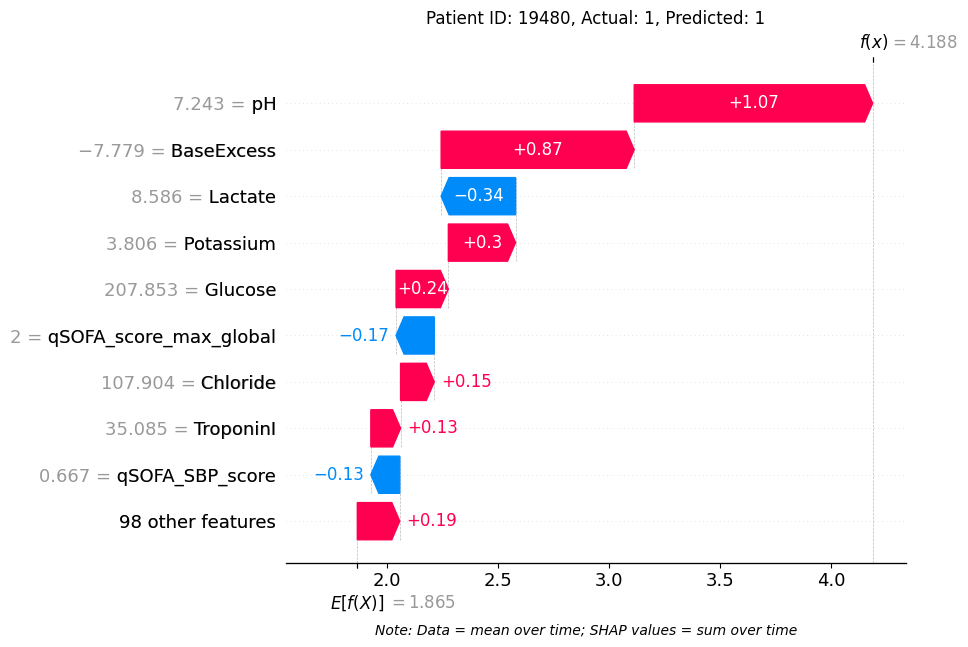

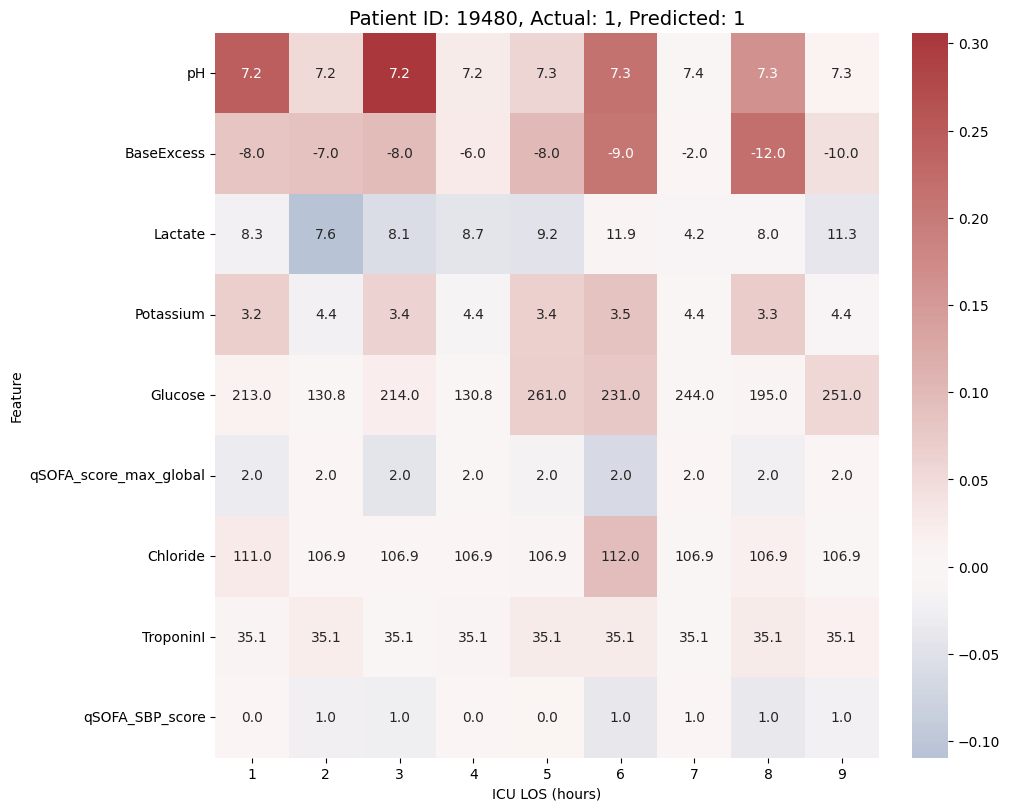

Actual:  1.0
Predicted:  0


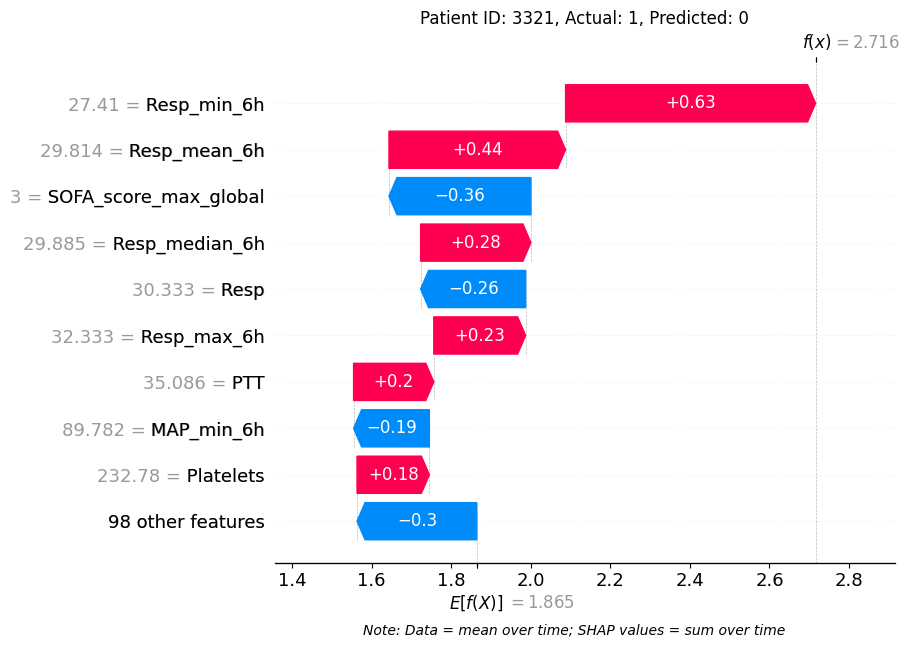

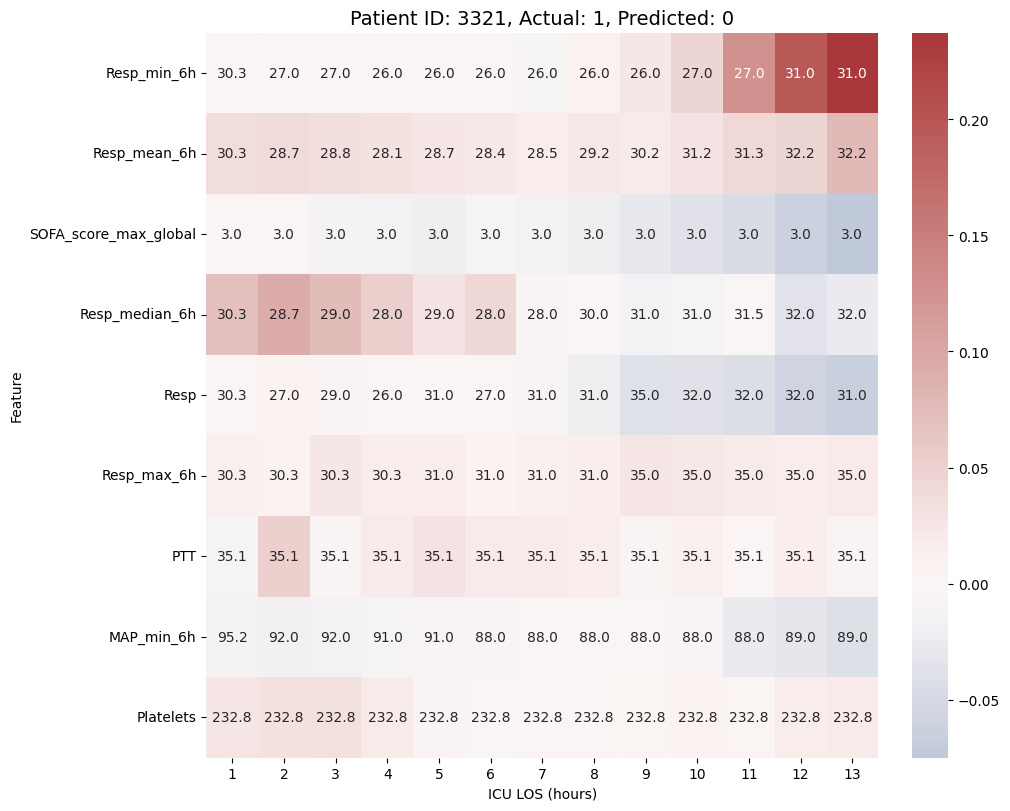

Actual:  1.0
Predicted:  1


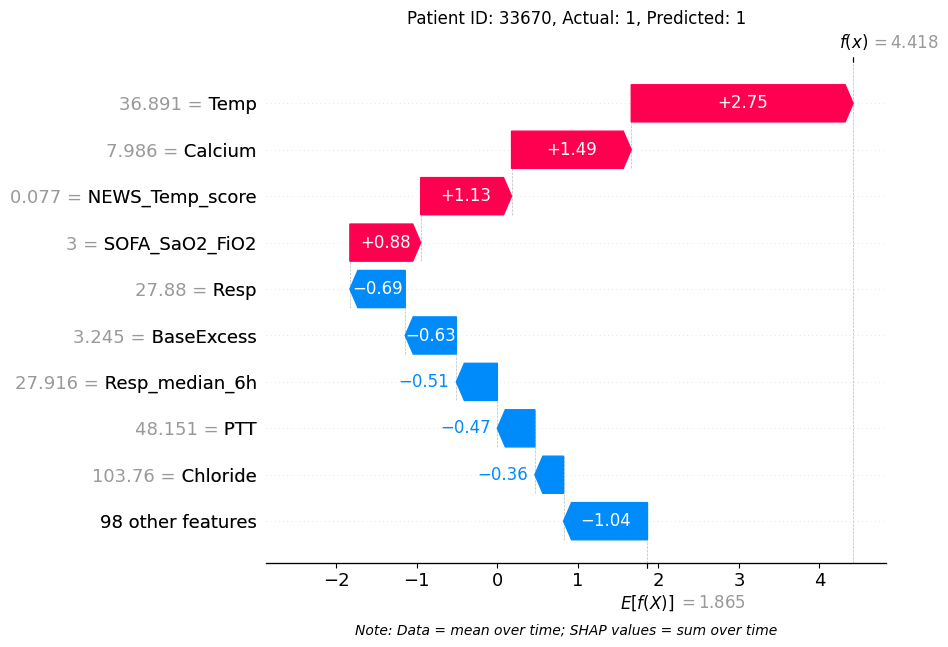

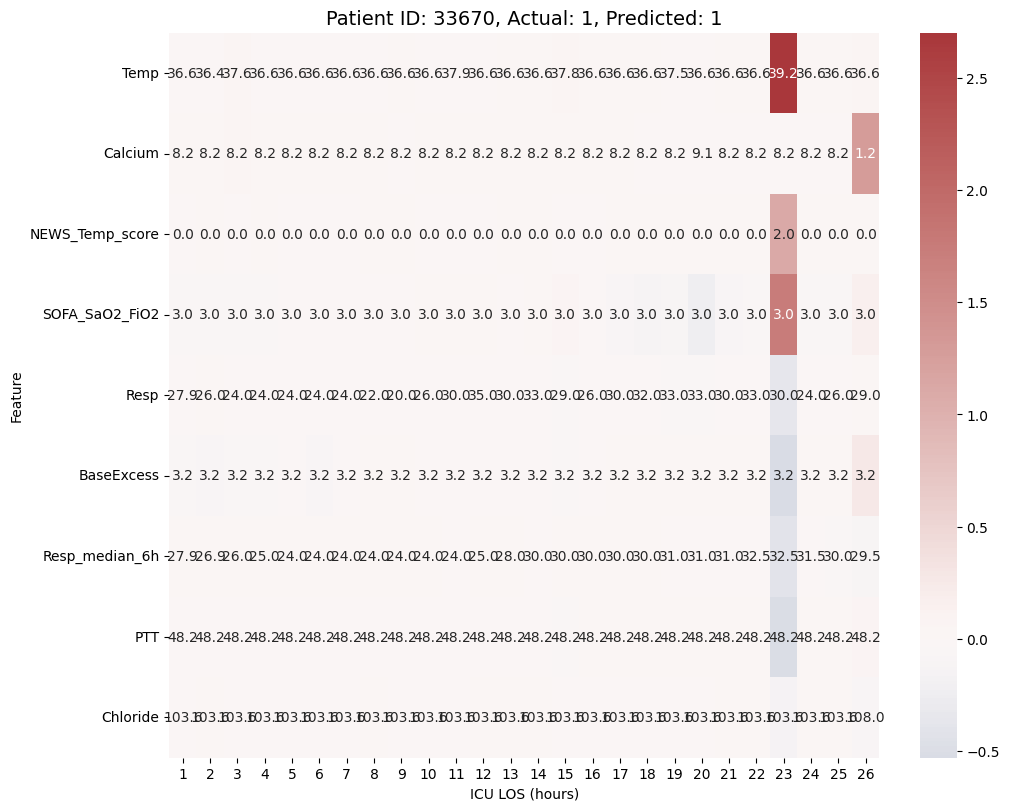

Actual:  1.0
Predicted:  0


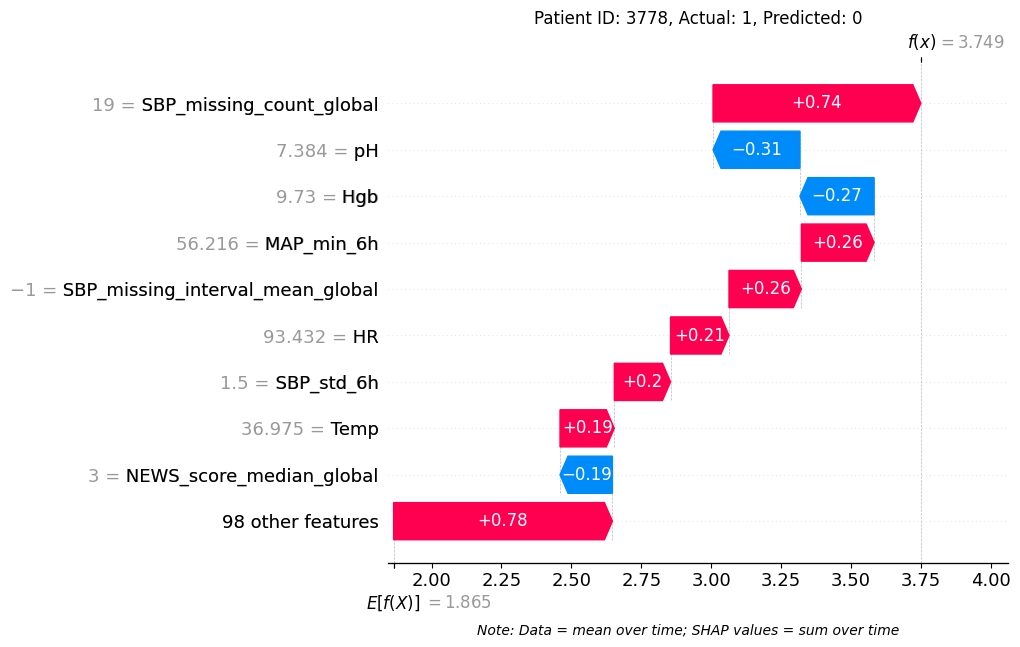

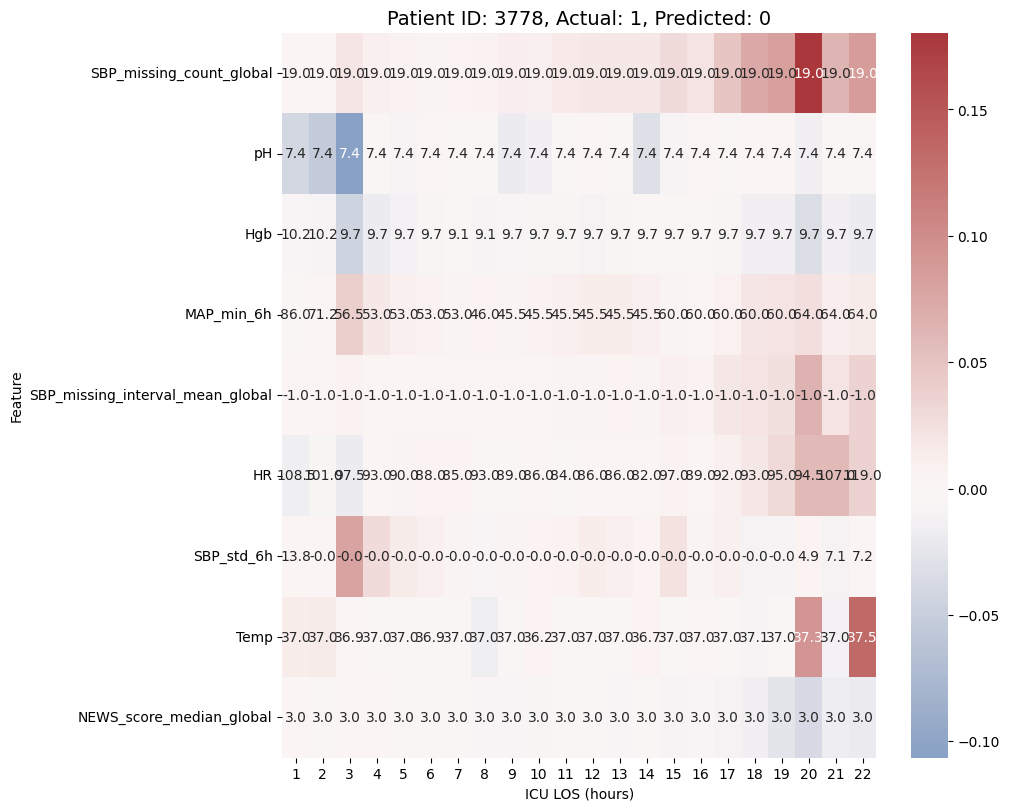

Actual:  1.0
Predicted:  0


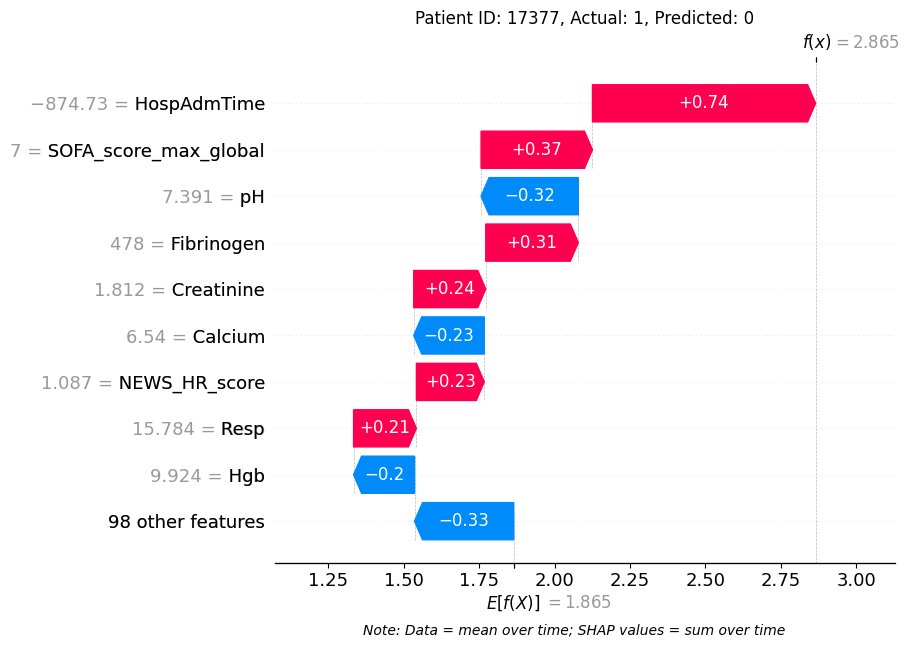

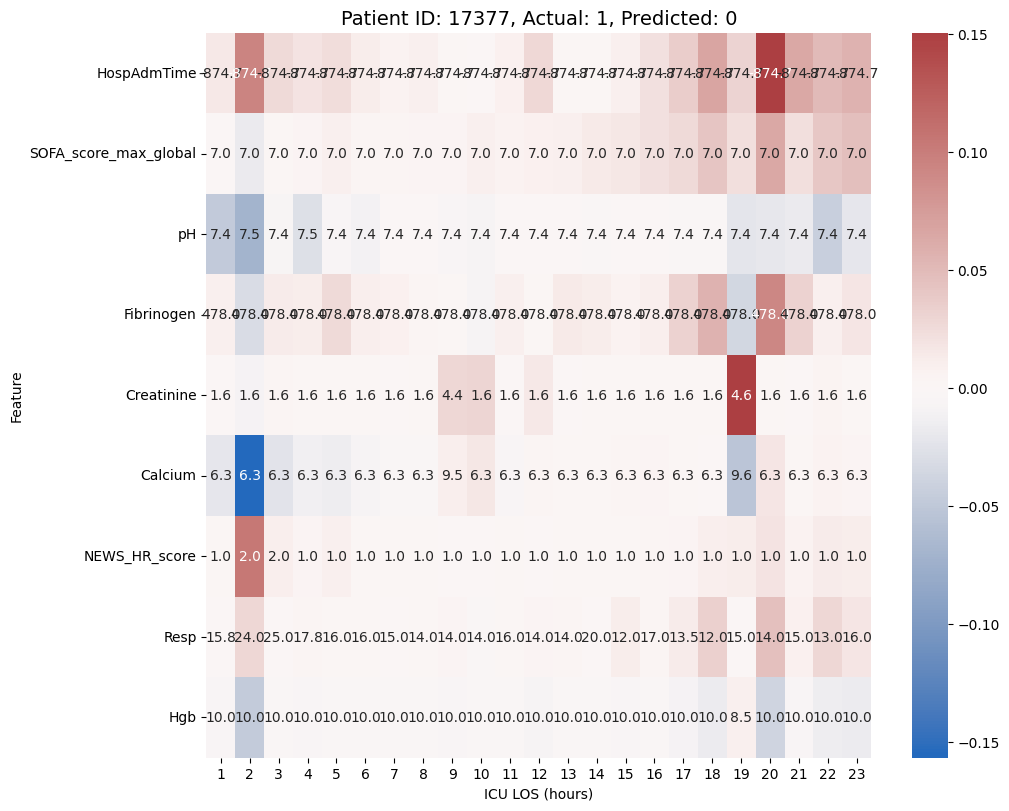

Actual:  1.0
Predicted:  1


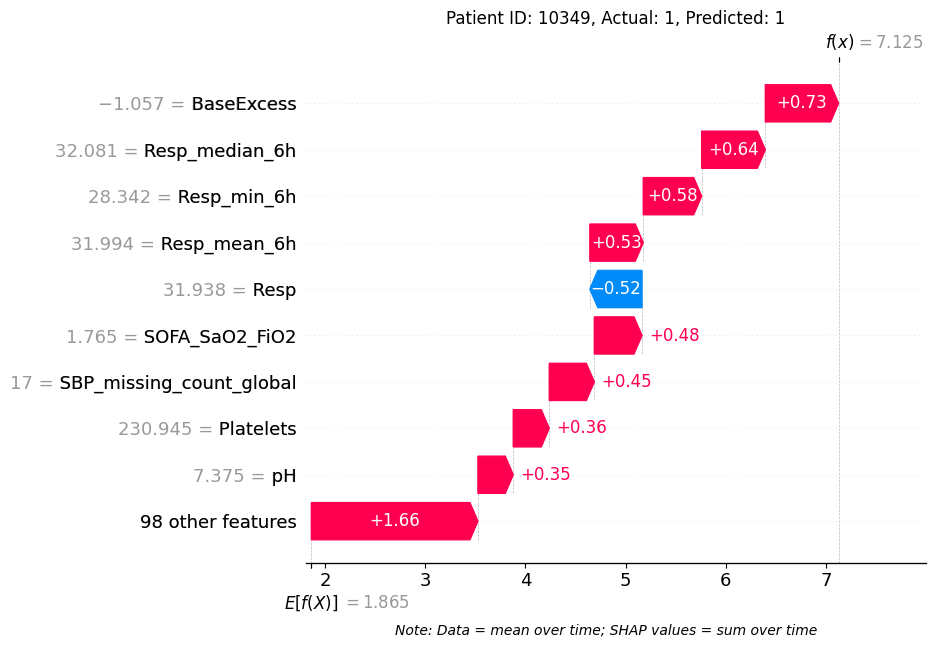

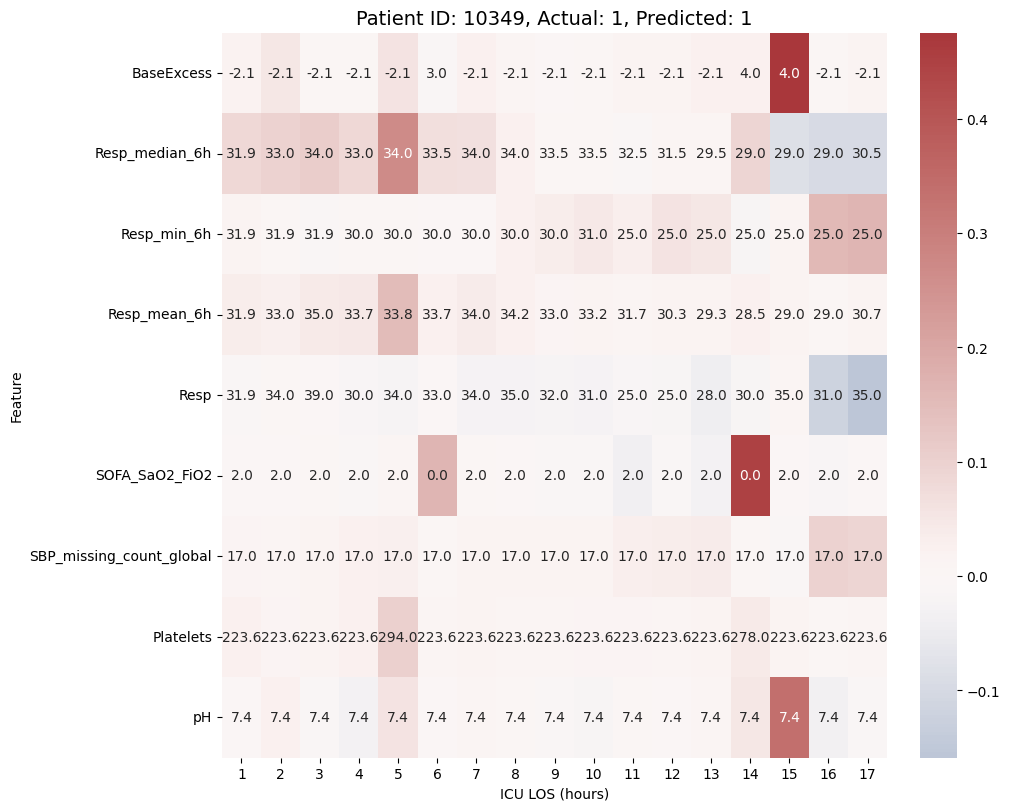

In [55]:
import matplotlib.pyplot as plt

for patient_id in sample_ids:
    i = patient_id_index_map[patient_id]
    mask = masks[i]
    true_mask = np.where(mask == 1)[0]
    patient_data = xvals[i, true_mask, :]
    patient_shap = shap_vals[i, true_mask, :]
    summed_shap_vals = np.sum(patient_shap, axis=0) # (F)
    mean_patient_data = patient_data.mean(axis=0)

    print("Actual: ", y_trues[i])
    print("Predicted: ", y_preds[i])

    shap.plots.waterfall(
        shap.Explanation(
            summed_shap_vals, 
            base_values=base_values, 
            data=mean_patient_data, 
            feature_names=feature_names
        ), 
        show=False
    )
    plt.title(f"Patient ID: {int(patient_id)}, Actual: {int(y_trues[i])}, Predicted: {int(y_preds[i])}")

    # Add the extra label under the title
    plt.figtext(0.5, 0.00, "Note: Data = mean over time; SHAP values = sum over time", wrap=True, ha='center', fontsize=10, style='italic')

    plt.show()

    # continue with the heatmap part
    time_index = np.array(list(range(1, shap_vals[i].shape[1] + 1)))
    y_true = y_trues[i]
    y_pred = y_preds[i]
    y_prob = y_probs[i]
    top_features = np.argsort(-np.abs(summed_shap_vals))[:9]
    annot_df = pd.DataFrame(patient_data, columns=feature_names)
    patient_heatmap(shap_vals, feature_names, time_index, annot_df=annot_df, idx=i, patient_id=patient_id, y_true=y_true, y_pred=y_pred, y_prob=y_prob, only_target_relevant=False, show=False, top_features=top_features)
    plt.show()

In [16]:
# # print waterfall pot for the first patient
# for patient_id in sample_ids:
#     i = patient_id_index_map[patient_id]
#     patient_shap_vals = shap_vals[i]
#     patient_data = np.array(xvals[i])
    
#     vector_feature_names = []
#     for s in range(0, patient_shap_vals.shape[0]):
#         for feature in feature_names:
#             vector_feature_names.append(feature + " (t=" + str(s + 1) + ")")

#     vector_shap_vals = patient_shap_vals.flatten()
#     vector_patient_data = patient_data.flatten()
#     print("Actual: ", y_trues[i])
#     print("Predicted: ", y_preds[i])
#     #print shapes
#     print(vector_shap_vals.shape)
#     print(vector_patient_data.shape)
#     print(len(vector_feature_names))

#     shap.plots.waterfall(shap.Explanation(vector_shap_vals, base_values=base_values,  feature_names=vector_feature_names), show=False)
#     # add patient id to the plot
#     plt.title(f"Patient ID: {patient_id}, Actual: {int(y_trues[i])}, Predicted: {int(y_preds[i])}")
#     plt.show()


In [ ]:
for patient_id in sample_ids:
    i = patient_id_index_map[patient_id]
    
    print("Patient ID: ", patient_id)
    print("Actual: ", y_trues[i])
    print("Predicted: ", y_preds[i])
    time_index = np.array(list(range(1, shap_vals[i].shape[1] + 1)))
    y_true = y_trues[i]
    y_pred = y_preds[i]
    y_prob = y_probs[i]
    patient_heatmap(shap_vals, feature_names, time_index, idx=i, patient_id=patient_id, y_true=y_true, y_pred=y_pred, y_prob=y_prob, only_target_relevant=False, show=False)
    plt.show()